# **TASK 3**

# 0. Setup

## 0.1 Import libraries.

In [ ]:
import numpy as np
import pandas as pd
import os

import random

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

from sklearn.utils import resample
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from numpy import where
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0.2 Utility

In [ ]:
df_path = '/content/drive/MyDrive/progetto-ml/data/'

In [ ]:
save_df = True

In [ ]:
n_components = 1
empty_element = 0.0
month_interval = 3
model_month_interval = True

In [ ]:
cardiovascular_events = ['AMD047', 'AMD048', 'AMD049', 'AMD071', 'AMD081', 'AMD082', 'AMD208', 'AMD303']

## 0.3 Model & Data

In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [ ]:
sequences = pd.read_csv(df_path + "norm_smote_seq.csv")
sequences = sequences.iloc[:,1:]

features = sequences.drop(columns = ["label"])
label = sequences["label"]
del sequences

In [ ]:
scaler = StandardScaler()
features[features.columns[:]] = scaler.fit_transform(features[features.columns[:]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=17)
X_train = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test.values, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
X_train.shape[1:]

(1, 1585)

In [ ]:
input_shape = X_train.shape[1:]

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    print(x)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(2, activation="softmax")(x)
    return keras.Model(inputs, outputs)

# 1. New Model

## 1.2 Train Model

In [ ]:
model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1585), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)

In [ ]:
model.summary()

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

In [ ]:
model.fit(
    np.asarray(X_train).astype('float32'),
    y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64,
    callbacks=callbacks,
)

Epoch 1/5
879/879 [==============================] - 361s 403ms/step - loss: 0.4240 - sparse_categorical_accuracy: 0.8080 - val_loss: 0.3408 - val_sparse_categorical_accuracy: 0.8470
Epoch 2/5
879/879 [==============================] - 342s 389ms/step - loss: 0.3548 - sparse_categorical_accuracy: 0.8408 - val_loss: 0.3371 - val_sparse_categorical_accuracy: 0.8493
Epoch 3/5
879/879 [==============================] - 349s 397ms/step - loss: 0.3447 - sparse_categorical_accuracy: 0.8466 - val_loss: 0.3303 - val_sparse_categorical_accuracy: 0.8515
Epoch 4/5
879/879 [==============================] - 354s 403ms/step - loss: 0.3369 - sparse_categorical_accuracy: 0.8473 - val_loss: 0.3252 - val_sparse_categorical_accuracy: 0.8551
Epoch 5/5
879/879 [==============================] - 356s 405ms/step - loss: 0.3326 - sparse_categorical_accuracy: 0.8496 - val_loss: 0.3289 - val_sparse_categorical_accuracy: 0.8431


In [ ]:
model.save(df_path + 'Model_Transformer_normalized.h5')

## 1.3 Test Model

In [ ]:
model = load_model(df_path + 'Model_Transformer_normalized.h5')

In [ ]:
model.evaluate(X_test, y_test, verbose=1)

550/550 [==============================] - 35s 60ms/step - loss: 0.3234 - sparse_categorical_accuracy: 0.8455


[0.32335278391838074, 0.8455409407615662]

In [ ]:
y_pred = model.predict(X_test)

550/550 [==============================] - 26s 46ms/step


In [ ]:
y_pred = y_pred.argmax(axis=-1)

In [ ]:
f_score = f1_score(y_test, y_pred)
print("F-Score: {:.5f}".format(f_score))

F-Score: 0.82868


In [ ]:
'''
[[true negative, false positive]
[false negative, true positive]]
'''
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[8293  569]
 [2145 6564]]


# 2. Bayesian Optimization

## 2.1 Optimize parameters

In [ ]:
!pip install bayesian-optimization

In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
def f(head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, mlp_dropout, dropout):
    model = build_model(
        input_shape,
        head_size=int(head_size),
        num_heads=int(num_heads),
        ff_dim=int(ff_dim),
        num_transformer_blocks=int(num_transformer_blocks),
        mlp_units=[int(mlp_units)],
        mlp_dropout=mlp_dropout,
        dropout=dropout,
    )
    model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
    )
    callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
    model.fit(
        np.asarray(X_train).astype('float32'),
        y_train,
        validation_split=0.2,
        epochs=2,
        batch_size=32,
        callbacks=callbacks,
    )
    return model.evaluate(X_test, y_test, verbose=1)[1]

performs Bayesian Optimization on 'hyperparameter_tuning' function, the optimization is performed

In [ ]:
optimizer = BayesianOptimization(f=f, pbounds={"head_size": (256, 512), "num_heads": (2, 4), "ff_dim":(2,4), "num_transformer_blocks":(1,4), "mlp_units":(1,2), "mlp_dropout": (0.001, 0.4), "dropout":(0.001, 0.25)})

In [ ]:
optimizer.maximize(init_points=3, n_iter=5)

|   iter    |  target   |  dropout  |  ff_dim   | head_size | mlp_dr... | mlp_units | num_heads | num_tr... |
-------------------------------------------------------------------------------------------------------------
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1585), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Epoch 1/2
1757/1757 [==============================] - 452s 251ms/step - loss: 0.6174 - sparse_categorical_accuracy: 0.7033 - val_loss: 0.5454 - val_sparse_categorical_accuracy: 0.8214
Epoch 2/2
550/550 [==============================] - 18s 33ms/step - loss: 0.5207 - sparse_categorical_accuracy: 0.8093
| 1         | 0.8093    | 0.2453    | 2.539     | 274.9     | 0.2859    | 1.386     | 3.484     | 2.957     |
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1585), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
Epoch 1/2
1757/1757 [==============================] - 556s 314ms/s

## 2.2 Model with Optimized Parameters

In [ ]:
print('best parameters settings: {}'.format(optimizer.max['params']))

best parameters settings: {'dropout': 0.011729020433894947, 'ff_dim': 3.9443966720714894, 'head_size': 413.8484917530443, 'mlp_dropout': 0.0370587601856176, 'mlp_units': 1.808701842869222, 'num_heads': 3.288932533102286, 'num_transformer_blocks': 2.5567913702315055}


In [ ]:
params = optimizer.max['params']

In [ ]:
head_size= int(params['head_size'])#413#
num_heads= int(params['num_heads'])#3#
ff_dim= int(params['ff_dim'])#3#
num_transformer_blocks= int(params['num_transformer_blocks'])#2#
mlp_units= int(params['mlp_units'])#1#
mlp_dropout= params['mlp_dropout']#0.0370587601856176#
dropout= params['dropout']#0.011729020433894947#

In [ ]:
model = build_model(
        input_shape,
        head_size = head_size,
        num_heads = num_heads,
        ff_dim = ff_dim,
        num_transformer_blocks = num_transformer_blocks,
        mlp_units = [mlp_units],
        mlp_dropout = mlp_dropout,
        dropout = dropout,
)

KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1585), dtype=tf.float32, name='input_11'), name='input_11', description="created by layer 'input_11'")


In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)

In [ ]:
model.summary()
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 1, 1585)]    0           []                               
                                                                                                  
 layer_normalization_38 (LayerN  (None, 1, 1585)     3170        ['input_11[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_19 (Multi  (None, 1, 1585)     7860562     ['layer_normalization_38[0][0]', 
 HeadAttention)                                                   'layer_normalization_38[0][0]'] 
                                                                                           

In [ ]:
model.fit(
    np.asarray(X_train).astype('float32'),
    y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=32,
    callbacks=callbacks,
)

Epoch 1/5
1757/1757 [==============================] - 737s 413ms/step - loss: 0.4674 - sparse_categorical_accuracy: 0.8097 - val_loss: 0.4282 - val_sparse_categorical_accuracy: 0.8395
Epoch 2/5
1757/1757 [==============================] - 686s 390ms/step - loss: 0.4119 - sparse_categorical_accuracy: 0.8313 - val_loss: 0.3907 - val_sparse_categorical_accuracy: 0.8466
Epoch 3/5
1757/1757 [==============================] - 672s 382ms/step - loss: 0.3878 - sparse_categorical_accuracy: 0.8363 - val_loss: 0.3695 - val_sparse_categorical_accuracy: 0.8520
Epoch 4/5
1757/1757 [==============================] - 673s 383ms/step - loss: 0.3760 - sparse_categorical_accuracy: 0.8378 - val_loss: 0.3612 - val_sparse_categorical_accuracy: 0.8512
Epoch 5/5
1757/1757 [==============================] - 663s 378ms/step - loss: 0.3676 - sparse_categorical_accuracy: 0.8409 - val_loss: 0.3518 - val_sparse_categorical_accuracy: 0.8557


In [ ]:
model.save(df_path+'Model_Bayesian_Transformer.h5')

## 2.3 Test

In [ ]:
model = load_model(df_path+'Model_Bayesian_Transformer.h5')

In [ ]:
model.evaluate(X_test, y_test, verbose=1)

550/550 [==============================] - 28s 51ms/step - loss: 0.3508 - sparse_categorical_accuracy: 0.8545


[0.3507903218269348, 0.8544761538505554]

In [ ]:
y_pred = model.predict(X_test)

550/550 [==============================] - 27s 48ms/step


In [ ]:
y_pred = y_pred.argmax(axis=-1)

In [ ]:
f_score = f1_score(y_test, y_pred)
print("F-Score: {:.5f}".format(f_score))

F-Score: 0.82991


In [ ]:
'''
[[true negative, false positive]
[false negative, true positive]]
'''
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[8776   86]
 [2471 6238]]


# 3. Comparison

## 3.1 Utility

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

plt.rcParams["figure.figsize"] = (6,5)

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def build_auc_plot(classifiers, X_data, y_data):
  fig, ax = plt.subplots()

  for classifier in classifiers:
    model_name = type(classifier).__name__
    y_pred = classifier.predict(X_data)
    y_pred = y_pred.argmax(axis=-1)
    fpr, tpr, _ = metrics.roc_curve(y_data,  y_pred)

    auc2 =  roc_auc_score(y_data, y_pred)
    plt.plot(fpr,tpr,label=f"{model_name}, auc={int(round(auc2*100))}%")

  plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')

  plt.legend()
  plt.show()

In [ ]:
def show_details(X_data, y_data, model, cv):
  model_name, classifier = model
  y_pred = classifier.predict(X_data)
  y_pred = y_pred.argmax(axis=-1)
  #cambiamento di X, Y in features, label
  estimator = KerasClassifier(build_fn= lambda : classifier, batch_size = 1, epochs = 100)
  # scores = cross_val_score(estimator, features, label, cv=cv)
  class_report = classification_report(y_data, y_pred)
  confusion = confusion_matrix(y_data, y_pred)
  roc = roc_auc_score(y_data, y_pred)
  _, accuracy = classifier.evaluate(X_data, y_data, verbose=1)

  print(f" {model_name} ".center(60, "="))

  print(class_report)
  print(confusion)
  print(f"{model_name} roc: {roc*100:.2f}%")
  # print(scores)
  # print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
  print(f"{accuracy * 100}% accuracy")

  disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=["0", "1"])
  disp.plot(cmap=plt.cm.Blues)
  disp.ax_.set_title(model_name)
  plt.show()

  build_auc_plot([classifier], X_data, y_data)

  print("\n\n")

In [ ]:
def create_report(X_data, y_data, classifiers, cv=5):
  report = {}

  for model_name, classifier in classifiers:
    y_pred = classifier.predict(X_data)
    y_pred = y_pred.argmax(axis=-1)

    estimator = KerasClassifier(build_fn= lambda : classifier, batch_size = 1, epochs = 100)
    report[model_name] = {}
    report[model_name]['roc'] = roc_auc_score(y_data, y_pred)
    report[model_name]['confusion_matrix'] = confusion_matrix(y_data, y_pred)
    #cambiamento di X, Y in features, label
    report[model_name]['cross_val'] = np.array([]) #cross_val_score(estimator, features, label, cv=cv)
    report[model_name]['metrics'] = classification_report(y_data, y_pred, output_dict=True)

  return report

In [ ]:
def build_cell(component, width=31):
  if type(component) == str:
    return component.center(width)
  elif type(component) == int:
    return f"{component}".center(width)
  elif type(component) == np.float64 or type(component) == float:
    return f"{component*100:.2f}%".center(width)
  elif type(component) == list or type(component) == set:
    return "|".join(map(lambda x: build_cell(x, width=width//len(component)), component))
  else:
    print(component)
    print(type(component))

In [ ]:
def build_row(components, width=31):
  center = "|".join([build_cell(component, width=width) for component in components])
  row = f"|{center}|"
  return row

In [ ]:
def build_table(rows, heading=None):
  if not rows:
    return ""

  rows = list(map(lambda x: build_row(x), rows))
  row_separator = "-" * len(rows[0])
  output = row_separator + "\n"

  if heading:
    output += build_row([ heading ], width=len(rows[0]) - 2) + "\n" + row_separator + "\n"

  for row in rows:
    output += row + "\n" + row_separator + "\n"

  return output

In [ ]:
def render_confusion_matrix(cf):
  return f"{cf[0][0]} {cf[0][1]} - {cf[1][0]} {cf[1][1]}"

In [ ]:
def render_cross_val(cv):
  return f"{cv.mean()*100:.2f}% ({cv.std():.2f})"

In [ ]:
def print_report(name, report):
  cv = len(list(report.values())[0]['cross_val'])

  rows = [
        [ '-', 'precision', 'recall', 'f1-score', 'support', 'roc', 'confusion matrix', f'cross val (cv={cv})' ],
        [ '(class)', ['0', '1'], ['0', '1'], ['0', '1'], ['0', '1'], '-', '-', '-' ]
  ]

  for model_name, data in report.items():
    metrics = [ [ data['metrics'][c][metric] for c in [ '0', '1' ] ] for metric in [ 'precision', 'recall', 'f1-score', 'support' ] ]
    row = [model_name, *metrics, data['roc'], render_confusion_matrix(data['confusion_matrix']), render_cross_val(data['cross_val'])]
    rows.append(row)

  print(build_table(rows, heading=name))

## 3.2 Print Comparison

In [ ]:
# testing parameters
LSTM_model = load_model(df_path+'Model_LSTM.h5')
TLSTM_model = load_model(df_path+'Model_T-LSTM.h5')
TRANSFORMER_model = load_model(df_path+'Model_Transformer_normalized.h5')
BAYESIAN_OPTIOMAZION_model = load_model(df_path+'Model_Bayesian_Transformer.h5')

In [ ]:
classifiers = [ ("LSTM", LSTM_model),
               ("T-LSTM", TLSTM_model),
               ("TRANSFORMER",TRANSFORMER_model),
               ("BAYESIAN OPTIMIZATION", BAYESIAN_OPTIOMAZION_model),
              ]

# see cv parameter
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score
cv_generator = 6

### 3.2.1 Train dataset

In [ ]:
report = create_report(X_train, y_train, classifiers, cv=cv_generator)
print_report("training set", report)

2197/2197 [==============================] - 110s 50ms/step
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|                                                                                                                          training set                                                                                                                         |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|               -               |           precision           |             recall            |            f1-score           |            support            |     

### 3.2.2 Test dataset

In [ ]:
report = create_report(X_test, y_test, classifiers, cv=cv_generator)
print_report("test set", report)

550/550 [==============================] - 26s 47ms/step
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|                                                                                                                            test set                                                                                                                           |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|               -               |           precision           |             recall            |            f1-score           |            support            |        

### 3.2.3. Confusion Matrixes

550/550 [==============================] - 2s 3ms/step - loss: 0.2882 - sparse_categorical_crossentropy: 0.2882
=========================== LSTM ===========================
              precision    recall  f1-score   support

           0       0.82      0.96      0.88      8862
           1       0.95      0.78      0.86      8709

    accuracy                           0.87     17571
   macro avg       0.88      0.87      0.87     17571
weighted avg       0.88      0.87      0.87     17571

[[8510  352]
 [1931 6778]]
LSTM roc: 86.93%
28.820541501045227% accuracy


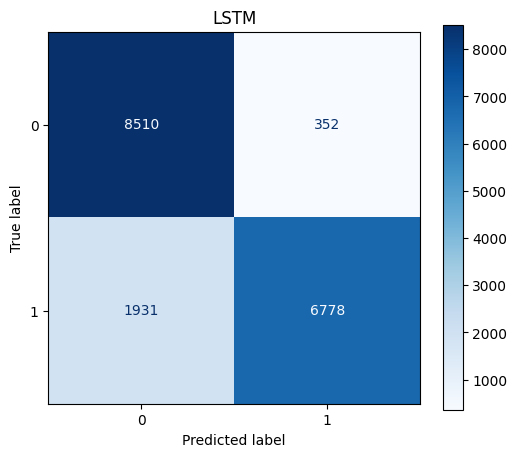

550/550 [==============================] - 1s 2ms/step


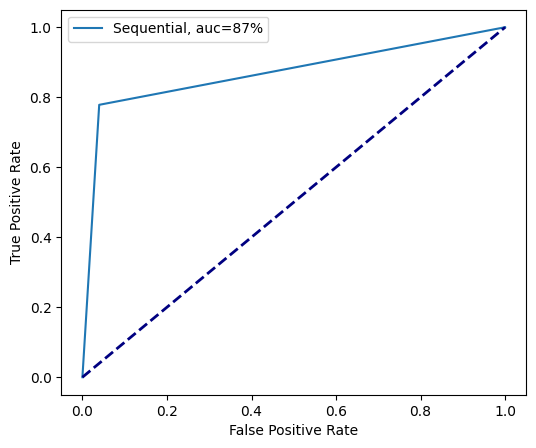




550/550 [==============================] - 2s 3ms/step - loss: 0.5159 - sparse_categorical_crossentropy: 0.5159
========================== T-LSTM ==========================
              precision    recall  f1-score   support

           0       0.74      0.75      0.74      8862
           1       0.74      0.73      0.74      8709

    accuracy                           0.74     17571
   macro avg       0.74      0.74      0.74     17571
weighted avg       0.74      0.74      0.74     17571

[[6627 2235]
 [2342 6367]]
T-LSTM roc: 73.94%
51.59384608268738% accuracy


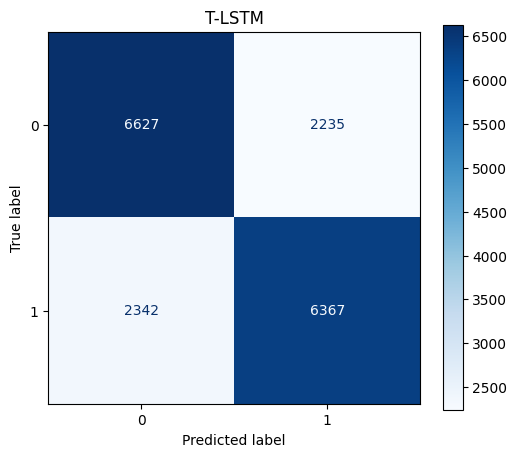

550/550 [==============================] - 1s 2ms/step


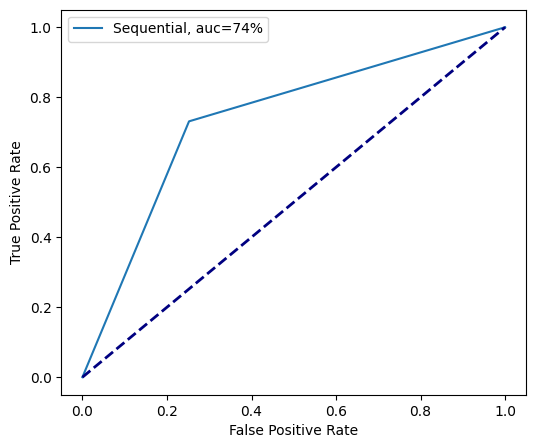




550/550 [==============================] - 44s 79ms/step - loss: 0.3234 - sparse_categorical_accuracy: 0.8455
======================= TRANSFORMER ========================
              precision    recall  f1-score   support

           0       0.79      0.94      0.86      8862
           1       0.92      0.75      0.83      8709

    accuracy                           0.85     17571
   macro avg       0.86      0.84      0.84     17571
weighted avg       0.86      0.85      0.84     17571

[[8293  569]
 [2145 6564]]
TRANSFORMER roc: 84.47%
84.55409407615662% accuracy


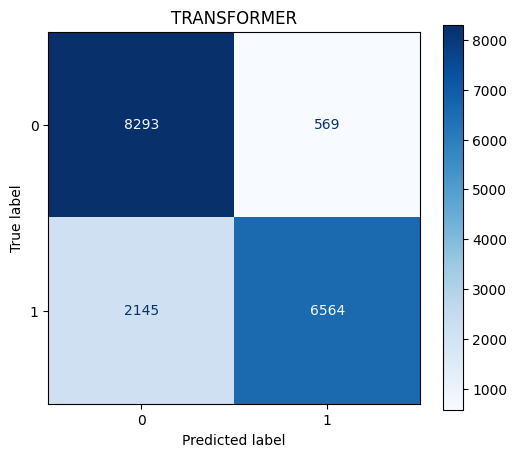

550/550 [==============================] - 42s 76ms/step


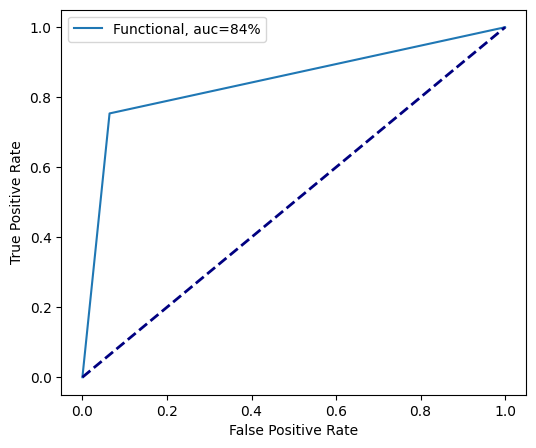




550/550 [==============================] - 27s 49ms/step - loss: 0.3508 - sparse_categorical_accuracy: 0.8545
================== BAYESIAN OPTIMIZATION ===================
              precision    recall  f1-score   support

           0       0.78      0.99      0.87      8862
           1       0.99      0.72      0.83      8709

    accuracy                           0.85     17571
   macro avg       0.88      0.85      0.85     17571
weighted avg       0.88      0.85      0.85     17571

[[8776   86]
 [2471 6238]]
BAYESIAN OPTIMIZATION roc: 85.33%
85.44761538505554% accuracy


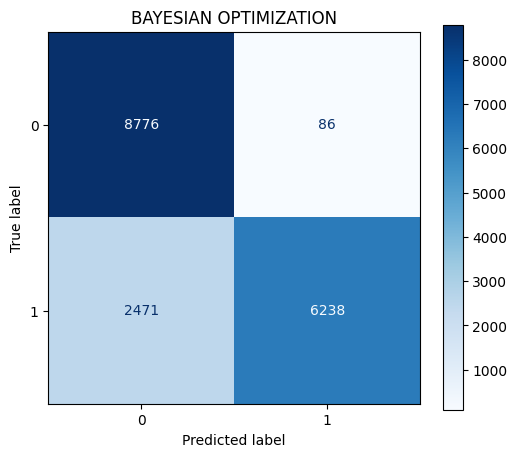

550/550 [==============================] - 27s 49ms/step


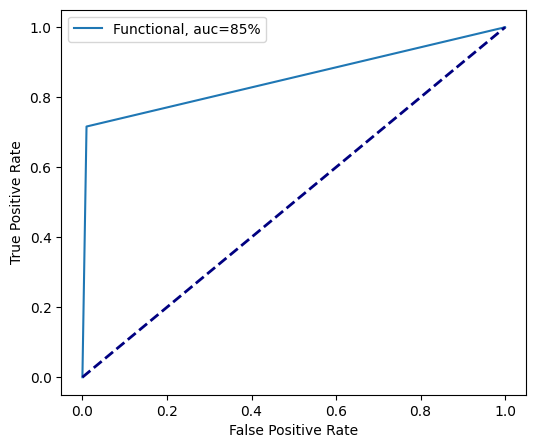

In [ ]:
for classifier in classifiers:
  show_details(X_test, y_test, classifier, cv=cv_generator)